# SoS Syntax

## Terminology & Grammar

A SoS **script** defines one or more **workflows**, and each workflow consists of one or more **steps**. 

SoS steps are defined by SoS **sections**. A SoS **section** consists of a **header** with one or more step names and optional options. The body of a SoS section consists of optional **comments**, **statements**, **input**, **output**, **depends** directives, **parameter** definitions, and external **task** definition. 


The following terms will be used throughout this documentation:

* **Script**: A SoS script that defines one or more workflows.
* **section**: A group of statements with a header that defines one or more SoS steps.
* **Workflow**: A sequence of steps that can be executed to complete certain task.
* **Step**: A step of a workflow that performs one piece of the workflow.
* **Target**: Objects that are input or result of a SoS step, which are usually files, but can also be objects such as executable commands and SoS variables.
* **Step options**: Options of the step that assist the definition of the workflow.
* **Step input**: Specifies the input files of the step.
* **Step output**: Specifies the output files and targets of the step.
* **Step dependencies**: Specifies the files and targets that are required by the step.
* **Step process**: The process that a step executes to complete specified work, specified as one or more Python statements. It consists of all statements after step input specification, or all statements in a step if no input is specified, excluding other SoS directives such as step output and dependencies.
* **Task**: Part or all step processes that will be executed outside of SoS, and potentially on a different server. These are usually resource intensive jobs that will take a long time to complete.
* **Action**: SoS or user-defined Python functions. They differ from regular Python functions in that they may behave differently in different running mode of SoS (e.g. ignore when executed in dryrun mode).

More formally defined, the SoS syntax obeys the following grammar, given in extended Backus-Naur form (EBNF):

```
Script         = {comment}, {step};
comment        = "#", text, NEWLINE
assignment     = name, "=", expression, NEWLINE
```

with SoS steps defined as

```
step           = [step_header],
                 {comment}, {{statement}, [input | output | depends ]},
                 [process, NEWLINE, {script} ]
step_header    = "[", step_names, [":", names | options], "]", NEWLINE
parameter      = "parameter", ":", assignment
input          = "input", ":", [expressions], [",", options], NEWLINE
output         = "output", ":", [expressions], [",", options], NEWLINE
depends        = "depends", ":", [expressions], [",", options], NEWLINE
task           = "task", ":",  [options]
action         = func_format | script_format
func_format    = name, "(", [options], ")"
script_format  = name, ":", [options], NEWLINE, script 
step_names     = step_name | step_pattern, ["(", text, ")"],
                 {",", step_name | steo_pattern, ["(", text, ")"]}
names          = name, {",", name}
workflow       = name, ['_', steps], {"+", name, ['_', steps}
assignment     = name, "=", expression, NEWLINW
expressions    = expression, {",", expression}
options        = option, {"," option}
option         = name, "=", expression
step_name      = letter, { letter | digit | "-" | "_" }
step_pattern   = {letter | digit | "*" | "?" | "-" | "_"}
```

Here `name`, `expression` and `statement` are arbitrary [Python 3](http://www.python.org) names, expression and statements with added SoS features.

**SoS is based on the Python 3 (3.6 and above) programming language**. If you are unfamiliar with Python, you can learn some basics of Python, usually in less than half a day, by reading some Python tutorials (e.g. [the official python tutorial](https://docs.python.org/3/tutorial/)). This [short introduction](https://docs.python.org/3/tutorial/introduction.html) is good enough for you to get started with SoS.

SoS adds the following syntax to standard Python syntax: 

| syntax | Example | Main Usage |
|--------|---------|-------|
|**Script format of function call**| `R: expand=True`<br>`  data <- read.csv("{_input}")`| Verbatim inclusion of scripts with optional indentation and string interpolation |
|**Section specification**| `[align_20]` | Define steps of workflows |
|**SoS statements**||Direct execution of steps|
|| **`parameter`**`: cutoff=10` | Obtain option from command line or workflow caller |
|| **`input`**`: fastq_files` | Specify input files of a step |
|| **`output`**`: f"{_input}.idx"` | Specify output files of a step |
|| **`depends`**`: hg19_fa` | Specify step dependencies |
|| **`task`**`: queue='cluster'` | Specify external tasks |


This chapter demonstrates general features such as string interpolation, section specification, parameter specification, and specification of workflows. Please refer to chapters [SoS Step](SoS_Step.html) and [Remote Exection](Remote_Execution.html) for more details on `input`, `output`, `depends`, and `task` statements.

## Script style function call

SoS allows you to write Python functions that accept a script (string) as the first parameter in a special script format. For example, an SoS function `R` that executes a script

```sos
R("""
pdf('output.pdf')
plot(0, 0)
dev.off()
""", workdir='result')
```

can be written as

```sos
R:  workdir='result'
pdf('output.pdf')
plot(0, 0)
dev.off()
```

SoS **automatically dedents scripts in script format** so that you can indent the scripts (add equal amount of leading white spaces to all lines) and write the above example as

```sos
R:  workdir='result'
   pdf('output.pdf')
   plot(0, 0)
   dev.off()
```

The latter is much preferred because it avoids trouble if the script contains SoS-like syntax such as `[1]` and `option:` and be treated as SoS directives, and more importantly, allows starting a new statement from a non-indented line. For example, `print('Hello world')` would be considered part of a R script in

```sos
R:  workdir='result'
pdf('output.pdf')
plot(0, 0)
dev.off()

print('Hello world')
```

but a separate statement in 

```sos
R:  workdir='result'
   pdf('output.pdf')
   plot(0, 0)
   dev.off()

print('Hello world')
```

The script format also accepts an option `expand` that **expands expressions enclosed in specified sigils** ([literal string interpolation](https://www.python.org/dev/peps/pep-0498/)). Using `expand=True`, the included script is converted to a Python f-string so that the string will be interpolated when it is executed. For example,

```
output = 'output.pdf'
R: workdir='result', expand=True
   pdf('{output}')
   plot(0, 0)
   dev.off()
```

will be translated to

```
output = 'output.pdf'
R(f'''\
pdf('{output}')
plot(0, 0)
dev.off()
''', workdir='result')
```
which will be expanded to

```
R('''\
pdf('output.pdf')
plot(0, 0)
dev.off()
''', workdir='result')
```
when the action is executed.

Although the use of expressions in literal string (`{ }` parts) is very convenient, the braces might conflict with the braces in languages such as R for which braces are widely used. The official method to include braces in such literal stringS is to double the braces (`{{ }}`)  as in the following example

In [1]:
a = 1
R: expand=True
    if ({a} == 1) {{
      cat("This is 1\n");
    }} else {{
      cat("This is not 1\n");
    }}

Generating myfigure.pdf


However, as you can imagine, inclusion of long scripts with lots of braces like this could be tedious and error-prone. For this reason, SoS allows you to use an alternative sigil for the format string. For example, using `expand='${ }'`, you can expand expressions inside `${ }` instead of `{ }` for string interpolation and do not have to double the braces.

In [2]:
a = 1
R: expand='${ }'
    if (${a} == 1) {
      cat("This is 1\n");
    } else {
      cat("This is not 1\n");
    }

Generating myfigure.pdf


The sigil specified by parameter `expand` should be a string with a single space separating left and right sigils (e.g. `"[ ]"`, `"s( )"`, `"< >"`). Note that the use of alternative sigils is just a convenient way for you to include large trunks of scripts with braces. Under the hood SoS will convert the string to properly formatted f-strings with doubled braces and `{ }` sigils.

As a final note, the SoS script format could be confused with Python's type hint syntax but SoS is able to tell the differences and treat them correctly:

In [3]:
var : str = 5
var

5

##  SoS Target classes

The concept of **target** plays an important role in SoS. A **target** is an object that that be created and detected. A SoS step can take a list of targets as input, check the existence of a list of dependent targets, and produce a list of targets as output. Targets can be created, removed, and their contents are tracked by SoS with **signatures**. For example, SoS can skip a workflow step if its output has been created, but will still rerun the step if the input file has been changed. A target can also be **zapped**, namely with its content replaced by its signature, so a target can be considered "exist" (so that a step can be skipped) but "non-exist" if the actual content is needed.

As illustrated by the following diagram, SoS supports a number of built-in targets such as `file_target`, `sos_variable`, `executable`, and targets defined by language modules such as `R_Library` for `R`. This section will describe general usage of targets and syntax for the most frequently used target `file_target`. Please refer to Chapter [Targets and Actions](Targets_and_Actions.html) for descriptions of other target types. Note that **SoS provides a very flexible and intuitive set of methods to work with files and list of files, gearing towards converting and using different formats of filenames in different scripts**. You do not have to understand all the technical details but learning how to use `path` and `path` would great facilitate the use of filenames in SoS.

![sos_step](../media/target_classes.png)

### File and directory names (`path` objects)

The `path` type handles the manipulation of file and directory names. It is derived from Python [pathlib.Path](https://docs.python.org/3/library/pathlib.html) so you can use any of the properties and functions defined for this class. For example,

In [4]:
p = path('~/sos-docs/src/documentation/SoS_Syntax.ipynb')

In [5]:
p.expanduser()

path('/Users/bpeng1/sos-docs/src/documentation/SoS_Syntax.ipynb')

In [6]:
p.name

'SoS_Syntax.ipynb'

In [7]:
p.parent

path('~/sos-docs/src/documentation')

In [8]:
p.parent / 'something.txt'

path('~/sos-docs/src/documentation/something.txt')

In [9]:
p.suffix

'.ipynb'

In [10]:
p.parts

('~', 'sos-docs', 'src', 'documentation', 'SoS_Syntax.ipynb')

In [11]:
p.exists()

False

In [12]:
p.is_dir()

False

In [13]:
p.with_name('SoS_Syntax.html')

path('~/sos-docs/src/documentation/SoS_Syntax.html')

In [14]:
p.with_suffix('.html')

path('~/sos-docs/src/documentation/SoS_Syntax.html')

and you can evaluate `path` in format strings as

In [15]:
f"Hello My name is {p.name}"

'Hello My name is SoS_Syntax.ipynb'

Note that `path` offers a [`os.PathLike`](https://docs.python.org/3/library/os.html#os.PathLike) interface and can be used directly with `os.path` functions such as

In [16]:
os.path.getsize(p.expanduser())

0

In [17]:
os.path.expanduser(p)

'/Users/bpeng1/sos-docs/src/documentation/SoS_Syntax.ipynb'

and while `p.expanduser()` returns a `path` object, the traditional `os.path.expanduser` returns a `str`.

On top of regular `pathlib.Path` functionalities, **`path` allows you to add `path` to a `str` and with a `str` as result**. So, for example, with

In [18]:
p = path('test.txt')

`p + '.tmp'` returns a string, which is essentially `str(p) + '.tmp'`

In [19]:
p + '.tmp'

'test.txt.tmp'

If you need a `path` as result, simply convert the `str` to `path` with

In [20]:
path(p + '.tmp')

path('test.txt.tmp')

The second difference is that `path` **accepts a list of format options to easily format path in different formats**:


| convertor |operation| effect | operant | output |
| :----------|:----| :----- | :----- | :-------|
| `a`       | absolute path  | `abspath(expanduser())` |  `~/SoS/test.sos` | `/path/to/user/SoS/test.sos` |
| `b`       | base filename  | `basename())` |  `~/SoS/test.sos` | `test.sos` |
| `e`       | escape  | `replace(' ', '\\ ')` | `file 1.txt` | `file\ 1.txt`|
| `d`       | directory name  | `dirname())` |  `~/SoS/test.sos` | `/path/to/user/SoS/` |
| `l`      | expand link   | `realpath(expanduser())` | `~/SoS/test.sos` | `/realpath/to/test.sos` |
| `n`      | remove extension   | `splitext()[0]` | `~/SoS/test.sos` | `~/SoS/test` |
| `p`     | posix name    | `replace('\\', '/')...` | `c:\\Users` | `/c/Users` | 
| `q`     |quote    | `quoted()` | `file 1.txt` | `'file 1.txt'`|
| `r`     | repr | `repr()` | `file.txt` | `'file.txt'` |
| `s`    | str | `str()` | `file.txt` | `file.txt` |
| `R`   | resolve remote and other targets | `.resolve()`| `remote('a.txt')` | `a.txt`|
| `u`   | expand user      | `expanduser()` | `~/SoS/test.sos` | `/path/to/user/SoS/test.sos`|
| `x`      | file extension   | `splitext()[1]` | `~/SoS/test.sos` | `.sos` |
| `,`   | join with comma      | `','.join()` | `['a.txt', 'b.txt']` | `a.txt,b.txt`|


These format options allow you to pass filenames to scripts in different formats. For example, it would be perfectly OK to pass `~/a.txt` to a shell script, but a `u` formatter should be added if you are passing the filename to a script that does not understand `~` in filenames. For example,

In [21]:
%preview -n name filename basefilename expanded parparname
file = path('~/sos/examples/update_toc.sos')
name = f"{file:n}"
filename = f"{file:b}"
basefilename = f"{file:bn}"
expanded = f"{file:u}"
parparname = f"{file:ddb}"

>>> name:

'~/sos/examples/update_toc'

>>> filename:

'update_toc.sos'

>>> basefilename:

'update_toc'

>>> expanded:

'/Users/bpeng1/sos/examples/update_toc.sos'

>>> parparname:

'sos'

The last example is pretty interesting because it applies three converters and gets the name of grand-parent directory using an equivalence of `basename(dirname(dirname(file)))`.

Note that, for completeness, we list the `R` formatter here although this formatter is used to resolve special targets, for example a `remote` target `remote(target)`, to a regular `BaseTarget` and an `executable` target to its command name. For example,

In [22]:
a = sos_targets(remote('file.txt'), sos_variable('some'))

In [23]:
f"{a}"

'remote("file.txt") sos_variable("some")'

In [24]:
f"{a:R,}"

'file.txt,some'

Finally, `path` formats the object with these format operators and then the resulting string with additional formatters. For example, you can format the `path` object as a regular string

In [25]:
f"{file:>50}"

'                     ~/sos/examples/update_toc.sos'

or apply `path` formatter (`bn` for base name of filename) and then as a regular string.

In [26]:
f"{file:bn>50}"

'                                        update_toc'

### Path list (`paths` object)

The `paths` type keeps a list of `path` objects. It can be initialized from one or more paths or lists of paths. Lists of paths will be flattened and concatenated so the end result will always be an one-dimensional list. The variables appear to be a sequence that can be sliced, iterated, and even compared to a regular list correctly. For example, the following statement creates a `paths` object with three filenames from a single filename and a list of two filenames:

In [27]:
targets = paths('a.txt', ['b.txt', 'c.txt'])
targets

[path('a.txt'), path('b.txt'), path('c.txt')]

You can access one or more elements of a `paths` or iterate through it

In [28]:
targets[2]

path('c.txt')

In [29]:
targets[1:]

[path('b.txt'), path('c.txt')]

In [30]:
for t in targets:
   print(t)

a.txt
b.txt
c.txt


To convert a `paths` object to a regular list, you can use function `list`

In [31]:
list(targets)

[path('a.txt'), path('b.txt'), path('c.txt')]

or slice part of the `paths` using slices

In [32]:
type(targets[1:])

list

The first big difference between the formatting of `paths` and regular lists of `path` is that **formatting are applied to each item and joint by space or comma**. For example, whereas a regular list is formatted as a list

In [33]:
target_list = ['a.txt', 'b.txt', 'c.txt']
f"{target_list}"

"['a.txt', 'b.txt', 'c.txt']"

A `paths` is formatted as

In [34]:
f"{targets}"

'a.txt b.txt c.txt'

or separated by `,` with format option `","` 

In [35]:
f"{targets:,}"

'a.txt,b.txt,c.txt'

or after formatting each element with specified formatter

In [36]:
f"{targets:r,}"

"'a.txt','b.txt','c.txt'"

One particular consequence of this format rule is that a `sos_targets` with only one element will appear the same as a single target so you can use `input` in place of `input[0]` if you know there is only one target inside `input`:

In [37]:
single = paths('SoS_Syntax.ipynb')
f"{single[0]} is the same as {single}"

'SoS_Syntax.ipynb is the same as SoS_Syntax.ipynb'

The second feature of the `paths` object that it will pass unknown attributes to the first `path` if the object only contains one `path`. That is to say, in many cases you can **use a `paths` with only one `path` just like a `path` object**.

For example,

In [38]:
single.suffix

'.ipynb'

In [39]:
single.resolve()

path('/Users/bpeng1/sos-docs/src/documentation/SoS_Syntax.ipynb')

In [40]:
os.path.getsize(single)

0

### File target (`file_target`)

A `file_target` is `path` and a `BaseTarget`. It can be created from a string or a `path`, and because the `BaseTarget` side of the interface is transparent to the users, it behaves exactly like a `path`. For this reason, `file_target` is rarely used directly in SoS scripts.

### Target list (`sos_targets`)

`sos_targets` is the type for all SoS system variables such as `input`, `_input`, `output`, `_output`, `depends`, `_depends`. They are created by SoS from `input:`, `output:` and `depends:` statements and are used to, for example, compose scripts in different languages.

`sos_targets` shares the same design as `paths` although its content is a list of `BaseTargets`. it can be created from `str`, `list`, `path`, `paths`, `file_targets`, and many other `BaseTarget` types. Although this type is very flexible, it closely resembles `paths` and share all its features.

For example, the `input` of the following step is a `sos_targets` object with a single `file_target` object, so it will be interpolated as a `file_target` object (without `[ ]` for a normal list):

In [41]:
input: 'SoS_Syntax.ipynb'

sh: expand=True
    wc -l {input}

       0 SoS_Syntax.ipynb


and if you have multiple input files, you can pass them altogether as a `sos_targets` with two `file_target` 
```
input = sos_targets('SoS_Syntax.ipynb', 'SoS_Magics.ipynb')
_input = sos_targets('SoS_Syntax.ipynb', 'SoS_Magics.ipynb')
```

In [42]:
input: 'SoS_Syntax.ipynb', 'SoS_Magics.ipynb'

sh: expand=True
    wc -l {input[0]}
    wc -l {input[1]}

       0 SoS_Syntax.ipynb
    2923 SoS_Magics.ipynb


Or separately as two groups of inputs:

In [43]:
input: 'SoS_Syntax.ipynb', 'SoS_Magics.ipynb', group_by=1

sh: expand=True
    wc -l {_input}

       0 SoS_Syntax.ipynb
    2923 SoS_Magics.ipynb


In this case, the step input contains two `file_target` (
```
input = sos_targets('SoS_Syntax.ipynb', 'SoS_Magics.ipynb')`
```
but the step process is executed twice, with 
```
_input = sos_targets('SoS_Syntax.ipynb')
_input = sos_targets('SoS_Magics.ipynb')
```
respectively. Because `_input` contains only one element, it is not necessary to use `_input[0]` in the script.

## Parameter and environment specification

### Command line options

SoS allows you to define parameters that accept values from command line options easily. 

#### Optional arguments

Any variable assignment prefixed with `parameter:` can accept values from command  line. The format of such lines are

```
# comment
parameter: var_name = default_value
```

The default value can be integer, float, boolean, string, list of string, or expressions that return values of these types. Other types can be used as long as they can be converted to these types from user-provided values. For example

In [44]:
# path to tool gatk
parameter: gatk_path = '~/bin/GATK'

defines a variable `gatk_path` with default value `'~/bin/GATK'`.

If you execute a workflow without defining `gatk_path`, the default value will be used

In [45]:
%run
parameter: gatk_path = '~/bin/GATK'
print(gatk_path)

~/bin/GATK


You can set this parameter from command line using option `--gatk_path`

In [46]:
%run --gatk_path /my/GATK
parameter: gatk_path = '~/bin/GATK'
print(gatk_path)

/my/GATK


You can also use `-` in place of `_` in command line, although the variable name cannot have `-` in it.

In [47]:
%run --gatk-path /my/GATK
parameter: gatk_path = '~/bin/GATK'
print(gatk_path)

/my/GATK


The default value of the parameter determines the type of values it accepts. For example, the following command yields an error because the parameter expects an integer (from default value `0`) but a string is passed.

In [48]:
%sandbox --expect-error

%run --cutoff zero
parameter: cutoff = 0

ArgumentError: argument --cutoff: invalid int value: 'zero'


Simiarly, a list would be created if the parameter has a default value of type list

In [49]:
%run --sample-names A
parameter: sample_names = []
print(sample_names)

['A']


Finally, the convention to specify `True` or `False` of a boolean parameter is to use `--no-PARAM` for `PARAM=False`. For example,

In [50]:
%run --no-trim
parameter: trim=True
print(trim)

False


#### Required arguments

In cases where there is no suitable default values and/or command line arguments are mandatory, you can specify a parameter without initial value, and the parameter will be considered required. By default, the parameter will be considered to be of a single value with `str` type.

In [51]:
%sandbox --expect-error

parameter: cutoff 
print(f"cutoff = {cutoff} of type {type(cutoff).__name__}")

ArgumentError: Argument cutoff of type str is required


In [52]:
%run --cutoff 100
parameter: cutoff 
print(f"cutoff = {cutoff} of type {type(cutoff).__name__}")

cutoff = 100 of type str


If you would like to specify a type, you can use the Python type hint to annotate the variable with a type

In [53]:
%run --cutoff 100
parameter: cutoff : int
print(f"cutoff = {cutoff} of type {type(cutoff).__name__}")

cutoff = 100 of type int


Currently SoS only accepts simple type hints such as `int`, `str`, `float`, `list` and only list of strings are supported:

In [54]:
%run --bam-files A.bam B.bam
# input bam files
parameter: bam_files : list
print(bam_files)

['A.bam', 'B.bam']


It is worth noting that you can specify type hint also for parameters with initial values but SoS will use type of the default values and ignore type hints in this case. For example, in the following case when a parameter with default value 10 are given a type hint of `list`, it will accept input as integers.

In [55]:
%run --cutoff 100
parameter: cutoff : list = 10
print(f"cutoff = {cutoff} of type {type(cutoff).__name__}")

cutoff = 100 of type int


### Configuration files

SoS reads configurations from 
* A site configuration file `site_config.yml` under the sos package directory
* A host configuration file `~/.sos/hosts.yml`
* A global sos configuration file `~/.sos/config.yml`
* And a configuration file specified by command line option `-c`.

The configuration files should be in [YAML format](http://www.yaml.org/start.html). Dictionaries defined in all these configuration files are merged to form a single dictionary that is available to SoS as a dictionary named `CONFIG`.

Note that:
* All configurations from the aforementioned files are merged to a single dictionary. A dictionary could therefore contain keys defined in different configuration files and a latter file could overwrite keys defined in a previous file. For example, if 
  * `{'A': {'B': 'old', 'C': 'old'}` is defined in `~/.sos/config.yml` and
  * `{'A': {'B': 'new', 'D': 'new'}` is defined in `my_config.yml`, then
  * dictionary `A` in `CONFIG` would have value `{'B': 'new', 'C': 'old', 'D': 'new'}`. 
* SoS interpolate string values in `CONFIG` if they contain `{ }`. The expressions enclosed by `{ }` would be evaluated with a local namespace that is the dictionary in which the key exists, and a global namespace that is the complete `CONFIG` dictionary. That is to say, if a configuration file contains
  ```
  user_name: user
  hosts:
    cluster:
      address: "{user_name}@domain.com:{port}"
      port: 123
   ```
  `CONFIG['hosts']['cluster']['address']` would be interpolated with `port` from the `CONFIG['host']['cluster']` and `user_name` from the top level `CONFIG['user_name']`. You will need to double the braces (`{{ }}` to include `{ }` in the config file.
* Because key `user_name` is frequently used in `hosts.yml`, SoS automatically defines `user_name` as the local user ID (all lower case) in `CONFIG` if it is not defined in any of the configuration files.
* A special key `based_on` will be processed after all configuration files are loaded. The value of `based_on` should be one or more keys to other dictionaries in the configuration (e.g. `hosts.cluster`. The consequence of this key is that the items from the referred dictionaries would be merged to the present dictionary if they do not exist in the present dictionary. This allows you to derive a dictionary from an existing one. For example, 
  ```
  hosts:
    head_node:
      description: head_node of cluster
      address: "{user_name}@domain.com:{port}"
      port: 123
      paths:
          home:   "/home/{user_name}"
    cluster:
      description: Cluster
      based_on: hosts.head_node
      queue_type: pbs
   ```
   allows `hosts["cluster"]` to be derived from `hosts["head_node"]`.

## Native SoS file format

A sos script can be defined in a plain text file. A `.sos` suffix is recommended but not required. A SoS script consists of **sections** that define **steps** of one or more **workflows**.

A SoS script usually starts with lines

```python
#!/usr/bin/env sos-runner
#fileformat=SOS1.0
```

The first line allows the script to be executed by command `sos-runner` if it is executed as an executable script. The second line tells SoS the format of the script. The `#fileformat` line does not have to be the first or second line but should be in the first comment block. The latest version of SOS format is assumed if no format line is present so it is a good practice to specify version of file format to make sure the script is interpreted correctly.

### Global sections and default variables

Global sections can be defined without section header in a `.sos` file as statements before any other section, and as a regular section with header `[global]`. The global sections are the only section that appear multiple times in a SoS script.

Definitions in the global section are shared by all sections so it is usually used to define global variables and parameters. SoS implicitly defines the following variables in the global section:

* **`SOS_VERSION`**: version of SoS interpreter.
* **`CONFIG`**: configurations read from site, hosts, global, local and user specific configuration files.

### SoS Sections

A SoS section is marked by a section header in the format of

```
[names: options]
```

The header should start with a `[` from the beginning of a line and end with a `]`. It can contain one or more names with optional description (for each step) and section options (for all steps defined in the section).

Section names of a section follow the following rules:

| Format | Example | Usage |
|--------|---| -------|
| **`name_index`** |`human_10`|Defines step `index` of workflow `name`. Here `name` can be any name with alpha-numeric characters and `-` and `_`. `index` should be a non-negative number.|
| **`name`** |`update-website`| Section name without index is equivalent to `name_0` |
| **`index`** |`10`| Section name without workflow name is equivalent to `default_index`|
| **`pattern_index`** |`*_0`, `human*_10`| Equivalent to step `index` of all matching workflows defined in the script. The `pattern` should follow [Unix filename matching](https://docs.python.org/2/library/fnmatch.html)|
| **`stepname (desc)`**| `10 (align)`| Optional short description can be used to describe the goal of the step|
| **`name1,name2,...`** |`human_10,mouse_10`| Comma separated names define multiple steps for one or more workflows|

A SoS step accepts the following options:

| Name | Example | Usage |
|------|--------|---------|
|**`skip`** | `skip`<br>`skip=False` | Always or conditionally skip a step, `expr` should be evaluated as `True` or `False`|
|**`shared`**|`shared='K'`<br>`shared={'K': 'output[0]'}`  | Variable that will be made available to the workflow after completion of the step |
|**`provides`**|`provides='filename'`<br>`provides=executable('fastqc')`<br>`provides='{filename}.bam.gz'`<br>`provides=['A1.txt', 'A2.txt']`| Targets that will be generated after the completion of the step. This option turns the step to an auxiliary step that will be executed when the provided target is needed. |

Please refer to section [SoS Step](SoS_Step.html) for more details on these options. 

A section can have arbitrary Python statements and SoS-specific statements that define the input, output, and dependent targets, and external tasks of the step.

|Keyword|Examples|Usage|
|-------|-------|-----|
|**`input`**| (unspecified)<br> `input: 'test1.txt', 'text2.txt'`<br>`input: '*.txt'` <br> `input: dynamic('*.txt')`| Input targets of the step, which can be derived from previous step (if unspecified), determined in advanced or only before the step is executed. |
|**`depends`**| `depends: 'hg19.fa'`<br>`depends: f"{_input}.idx"`<br>`depends: R_library('ggplot2')`| Step depends on a specified files or targets to execute |
|**`output`**| (unspecified) <br>`output: 'output.bam'`<br>`output: f'{_input}.idx'`| Step has no or specified defined output that can be derived from input files |
|**`task`**|`task:`| Statements following the statement will be executed as an external task|

These statements accept a large number of options to specify how input, output targets are processed and how external tasks are executed. Please refer to section [SoS step](SoS_Step.html) for more details about different types of steps and step options, and section [Remote Exection](Remote_Execution.html) on topics related to external tasks.

As an example for a complete script, the following script defines a workflow with a global section without header, and a workflow `gff` with two steps

```sos
#!/usr/bin/env sos-runner
#fileformat=SOS1.0

local_resource = '~/Resource/'
data_dir       = '~/Data/bams/'
resource_dir   = f'{local_resource}/resources/hg19/Ensembl/Genes'

# samples to be processed
parameter: samples = ['s312', 's315', 's312a', 's315a']

[gff_0]
# download gene models from the MISO website
output: f'{resource_dir}/Home_sapiens.GRCh37.65.gff.zip'
download: dest_dir=resource_dir, decompress=True
    http://genes.mit.edu/burgelab/miso/annotations/gene-models/Homo_sapiens.GRCh37.65.gff.zip

[gff_1]
# Index gtf file using index_gff
output: f'{resource_dir}/{hg19_gff_index}/genes.gff'
task:   working_dir=resource_dir
run:    docker_image='mdabioinfo/miso:latest'
    rm -rf {hg19_gff_index}
    index_gff --index {hg19_gff_file} {hg19_gff_index}
```

## Jupyter notebook format

SoS provides a Jupyter frontend in which you can execute sos steps and workflows interactively or in batch mode. The Jupyter notebook format `.ipynb` can contain **markdown cells** and **code cells** with statements in SoS and any other supported languages (e.g. `R`).

One or more SoS workflows can be defined in a `.ipynb` file from **code cells in SoS kernel that start with section headers**. For example, the same workflow defined in the `.sos` file could be defined in a Jupyter notebook, with cells starting with section headers as follows: 

In [56]:
[global]
local_resource = '~/Resource/'
data_dir       = '~/Data/bams/'
resource_dir   = f'{local_resource}/resources/hg19/Ensembl/Genes'

# samples to be processed
parameter: samples = ['s312', 's315', 's312a', 's315a']

In [57]:
[gff_0]
# download gene models from the MISO website
output: f'{resource_dir}/Home_sapiens.GRCh37.65.gff.zip'
download: dest_dir=resource_dir, decompress=True
    http://genes.mit.edu/burgelab/miso/annotations/gene-models/Homo_sapiens.GRCh37.65.gff.zip

In [58]:
# This is step 1 of the gff workflow
[gff_1]
# Index gtf file using index_gff
output: f'{resource_dir}/{hg19_gff_index}/genes.gff'
task:   working_dir=resource_dir
run:    docker_image='mdabioinfo/miso:latest', expand=True
    rm -rf {hg19_gff_index}
    index_gff --index {hg19_gff_file} {hg19_gff_index}

Note that

* SoS cells that start with section header (after optional comments, empty lines, and magics) are **workflow cells**. These cells are excluded from usual cell evaluation but can be executed using magics `%run` and `%sosrun`.  
* The `[global]` section header is needed for the global section to be recognized as part of a workflow.
* A cell can define one or more steps, even a complete workflow.

SoS commands such as `sos run` and `sos-runner` can execute workflows defined in `.ipynb` files directly.

## Workflow Specification

### Forward-style workflows

A SoS forward-style workflow has a name and one or more numbered steps. The workflows are defined from sections in a SoS script. 

For example, the following sections specify a workflow with four steps `5`, `10`, `20`, and `100`. The workflow steps can be specified in any order and do not have to be consecutive.

In [59]:
[5]
[20]
[10]
[100]

A workflow specified in this way is the **`default`** workflow and is actually called `default` in SoS output. You can specify a workflow with name and give each step a short description as follows:

In [60]:
[mapping_5 (get data)]
[mapping_20 (align)]
[mapping_10 (quality control)]
[mapping_100 (generate report)]

A SoS script can define multiple workflows. For example, the following sections of SoS script defines two workflows named ``mouse`` and ``human``. 

In [61]:
[mouse_10]
[mouse_20]
[mouse_30]
[human_10]
[human_20]
[human_30]

In this case, a command line option is needed to specify workflow name. This can be done by magic `%run` in Jupyter notebook, or a positional argument from the command line, e.g.

```
    % sos run myscript mouse
```

Note that the workflow argument is not needed if a `default` workflow is defined in the script like the following example

In [62]:
[10]
[20]
[30]
[test_10]
[test_20]
[test_30]

Multiple steps can share a single step as follows

In [63]:
[mouse_10,human_10]
[mouse_20]
[human_20]
[mouse_30,human_30]

and wildcard steps can be used to define a step for multiple workflows:

In [64]:
%run mouse
[*_10]
[mouse_20]
[human_20]
[*_30]

If the steps defined in a shared section is similar but not identical, it can use step variable (discussed elsewhere) `step_name` to behave differently in different workflows. In the following example, the variable `step_name` will be `mouse_20` or `human_20` depending on the workflow being executed, and is used to determine the correct reference genome for different workflows.

In [65]:
[mouse_20,human_20]
reference = "/path/to/mouse/reference" if \
  step_name.startswith('mouse') else "/path/to/human/reference"

print(f"Reference genome {reference} is used")

### Sub- and combined workflows

Although workflows are defined separately with all their steps, they do not have to be executed in their entirety. A `subworkflow` refers to a workflow that is defined from one or more steps of an existing workflows. It is specified using syntax `workflow:[from-to]` where `from-to` can be `n` (step `n`), `-n` (up to `n`), `n-m` (step `n` to `m`) and `m-` (from `m`). For example

```python
A              # complete workflow A
A:5-10         # step 5 to 10 of A
A:50-          # step 50 up
A:-10          # up to step 10 of A
A:10           # step 10 of workflow A
```

In practice, the `-n` format is frequently used to execute part of the workflow for debudding purposes, for example:

In [66]:
%run default:-20
[10]
print(step_name)
[20]
print(step_name)
[30]
print(step_name)

default_10
default_20


You can also combine subworkflows to execute multiple workflows one after another. For example,

```python
A + B          # workflow A, followed by B
A:0 + B        # step 0 of A, followed by B
A:-50 + B + C  # up to step 50 of workflow A, followed by B, and C
```

This syntax can be used from the command line, e.g.

```bash
sos-runner myscript align+call
```

or from the `%run` magic of Jupyter notebook

In [67]:
#local run
%run check+align+call
[check_10]
print(step_name)
[align_10]
print(step_name)
[align_20]
print(step_name)
[call_10]
print(step_name)
[call_20]
print(step_name)

check_10
align_10
align_20
call_10
call_20


### Nested workflow (`sos_run`)

SoS also supports nested workflow in which a complete workflow is treated as part of a step process.
The workflow is execute by SoS action `sos_run`, e.g.

```python
sos_run('A')            # execute workflow A
sos_run('A + B')        # execute workflow B after A
sos_run('D:-10 + C')    # execute up to step 10 of D and workflow C

# execute user-specified aligner and caller workflows
sos_run(f'{aligner} + {caller}')  
```

In its simplest form, nested workflow allows you to define another workflow from existing ones. For example,

align_10
align_20
call_10
call_20


> forward.dot (123 B):

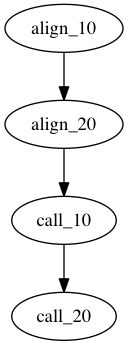

In [68]:
%preview -n forward.dot
%run -d forward
[align_10]
print(step_name)
[align_20]
print(step_name)
[call_10]
print(step_name)
[call_20]
print(step_name)
[default]
sos_run('align+call')

defines a nested workflow that combines workflows `align` and `call` so that the workflow will by default execute two workflows, but can also execute one of them as separate workflows `align` and `call`. This example also uses option `-d` to output the execution path of the workflow to a file, and magic `%preview` to preview the path.

Nested workflow also allows you to define multiple mini-workflows and connect them freely. For example

```python
[a_1]
[a_2]
[b]
[c]
[d_1]
sos_run('a+b')
[d_2]
sos_run('a+c')
```

defines workflows `d` that will execute steps `d_1`, `a_1`, `a_2`, `b_0`, `d_2`,  `a_1`, `a_2`, and `c_0`. 

A `parameter` statement usually gets its value from command line. However, when a workflow is executed as a subworkflow by action `sos_run`, the `parameter` statement can get its value from the `args` or `**kwargs` parameters of `sos_run`.

For example, when the `default` workflow of the following script is executed, `cutoff` takes its default value of `10`. 

In [69]:
%run
[default_1]
parameter: cutoff=10
run: expand=True
  echo {cutoff}

[batch]
for cutoff in range(3):
    sos_run('default', cutoff=cutoff)

echo 10
10



A command line argument can be used to set this parameter to `8`,

In [70]:
%rerun --cutoff 8

echo 8
8



Now, if the workflow is called as a subworkflow of step `batch`, `sos_run` set up the environment so that the statement `parameter: cutoff=10` gets a different cutoff value pass by  `sos_run`.

In [71]:
%rerun batch 

echo 0
0

echo 1
1

echo 2
2



Because `sos_run` is simply a SoS action and takes a string as its parameter, it allows very flexible ways to compose (e.g. determine workflow from command line arguments) and execute (e.g. repeated execution of workflows with different options or input files) complex workflows. Furthermore, the workflows can be defined in another file so you can organize your workflow as a master workflow that calls nested workflows defined in other files.

For example, suppose we create a workflow with two steps:

In [72]:
%preview -n nested.sos
%run

[10]
report: output='nested.sos'
  [nested_20]
  print(f"This is {step_name} of a nested workflow")
  
  [nested_30]
  print(f"This is {step_name} of a nested workflow")


> nested.sos (128 B):

[nested_20]
print(f"This is {step_name} of a nested workflow")

[nested_30]
print(f"This is {step_name} of a nested workflow")


Then, we can execute this workflow with a `sos_run` action as follows

In [73]:
sos_run('nested', source='nested.sos')

This is nested_20 of a nested workflow
This is nested_30 of a nested workflow


### Makefile-style workflow

Using **auxiliary steps** that are only executed to provide desired output, a SoS workflow can be constructed dynamically to produce the specified target. For example, the following pipeline does not have any numbered steps and is triggered by option `-t test.vcf` (target).

exists() takes 1 positional argument but 2 were given


> target.dot (118 B):

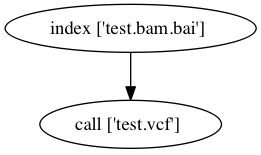

In [74]:
%sandbox
# preview multiple DAG
%preview -n target*.dot
!touch test.bam

%run -t test.vcf -d target

# this step provides variable `var`
[index: provides='{filename}.bam.bai']
input: f"{filename}.bam"
run: expand=True
   echo "Generating {output}"
   touch {output}

[call: provides='{filename}.vcf']
input:   f"{filename}.bam"
depends: f"{input}.bai"
run: expand=True
   echo "Calling variants from {input} with {depends} to {output}"
   touch {output}

In this example, SoS first look for a step that can produce `test.vcf` and found the `call` step through pattern `{filename}.vcf`. It turns out that this step requires an existing input file `test.bam` but a missing dependent file `test.bam.bai`, so it continues to check the workflow to identify step `index` that generates `test.bam.bai` from `test.bam`. With all dependencies met, as illustrated by the DAG (Direct Acyclic Graph) of this workflow, two steps, `index` and `call` are executed to produce the output `test.vcf`. Please refer to a [tutorial on auxiliary steps](../tutorials/Auxiliary_Steps.ipynb) for details.

### Mixed style workflows

Auxiliary steps provide a mechanism to produce missing targets and can also be used in forward-time workflows. The resulting workflows have a numbered "stem" steps and an arbitrary number of auxiliary steps that provide required input and dependent files for these steps. For example, the following example demonstrates the use of a nested workflow with two forward-style workflows with assistance from two auxiliary steps.

In [ ]:
%sandbox

%preview -n mixed*.dot
%run -d mixed

[align_10]
depends: 'hg19.fa'
print(step_name)
[align_20]
print(step_name)
[call_10]
depends: 'dbsnp.vcf', 'hg19.fa'
print(step_name)
[call_20]
print(step_name)
[default]
sos_run('align+call')

[refseq: provides='hg19.fa']
run:
    # a real step would download a fasta file for hg19
    touch hg19.fa

[dbsnp: provides='dbsnp.vcf']
run:
    touch dbsnp.vcf


## Modularize SoS Workflow

SoS encourages verbatim inclusion of scripts in a single SoS Script (or Notebook) so that the entire workflow can be self-contained, easily readable and modifiable, can be easily versioned, archived and shared. Such workflows are robust to changes in dependent scripts or modulars and therefore more reproducible.

However, there are certainly cases when it makes more sense to keep parts of the workflow outside of a SoS script, user cases include but not limited to

1. Parts of workflow that are meant to be the same across multiple workflows (e.g. a workflow to deliver and archive results).
2. Scripts that are long, or multi-file in nature, or functions that are designed to be reused by multiple scripts in the same or across SoS workflows.

SoS provides a number of features that allow the inclusion, importing, or execution of external functions, scripts, or workflows. They are scattered around the documentation so here is a summary of what you can do to modularize your SoS workflow:

|Method | Example | Pros | Cons | Comment|
|---|---|---|---|--|
|**utility modules and libraries** | `import my_module` in Python, `library(my_library)` in R etc | Most clean, and can be used for highly reusable components that worth the effort to formalize and maintain them. | It can be difficult to keep the modules backward compatible so changes in such modules might make a previous workflow non-reproducible. | It is usually not practical to rerun archived projects just to test compatibility of these modules. |
|**include shared configurations or functions** | `python: input='utility.py'` | Easier to maintain than modules, include the same scripts across actions or workflows | Without proper wrapping and testing, such functions tend to be changed easily and break previous workflow | Suitable only for configuration and functions that do not need to be changed. |
|**nested workflow**| `sos_run(source="file.sos")`| Allows the separation of a big workflow to multiple smaller workflows maintained in different SoS workflows. Very flexible because the workflows and sources can be determined programmatically.| The workflows should be logically and functionally separated so that changes in one workflow will not break the entire workflow. | Suitable for the creation of large workflows. |
|**external commands**| `sh("sos run workflow")` in SoS or `!sos run workflow` in SoS Notebook | Similar to `sos_run` in SoS | Similar to `sos_run` in SoS | Useful for SoS notebooks with standardized sub-workflows |